In [1]:
%matplotlib inline
import ogr
import shapely
from shapely.geometry import *
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import gdal

# Bogotá en mapa 

El objetivo de los tomadores de decisiones de la ciudad es reducir la brecha de desigualdad, generando alternativas serias de movilidad para las personas más vulnerables, brindando las mismas oportunidades a personas con condiciones socioeconómicas tanto favorables como vulnerables. La estratificación clasifica grupos de personas que tienen condiciones sociales y económicas similares [Mayor información sobre estratificación](http://www.sdp.gov.co/portal/page/portal/PortalSDP/InformacionTomaDecisiones/Estratificacion_Socioeconomica/QueEs). A pesar de que la estratificación se hace netamente con la úbicación del predio, un análisis válido consiste en determinar la accesibilidad de las zonas de estratos bajos con respecto a los estratos altos. El ejercicio final propuesto en este taller, consiste en analizar la composición de estratos por cada localidad y su accesibilidad a través de la comparación de tiempos de viaje hacía los diferentes estratos

Durante este taller se reforzarán las siguientes áreas:

- Manejo de datos georeferenciados.
- Creación de nuevas columnas en Pandas.
- Manejo de Geopandas.
- Limpieza de información usando OpenStreetMap.
- Limpieza de archivos y filtrado de información útil en Python.
- Generación de gráficos en Plotly.

Para la realización de este Notebook se requiere la instalación de `gdal` and `cufflinks`

```bash
conda install gdal
pip install cufflinks
```

# 1 - Abrir archivos

Para este punto se van a usar los siguientes archivos:
- `bogota_cadastral.json`: contiene la información georeferenciada de 1160 zonas que componen a la ciudad de Bogotá D.C. (Incluído Sumapaz)
- `bogota-cadastral-2017-2-OnlyWeekdays-HourlyAggregate.csv`: contiene la información de viajes entre semana entre un origen y un destino en la ciudad de Bogotá, para el segundo trimestre de 2017. Se encuentra discriminada por la hora en la que se realizó el viaje.
- `bogota-cadastral-2016-2-OnlyWeekdays-HourlyAggregate.csv`: contiene la información de viajes entre semana entre un origen y un destino en la ciudad de Bogotá, para el segundo trimestre de 2016. Se encuentra discriminada por la hora en la que se realizó el viaje.

### **Genere un mapa cloroplético de los tiempos de desplazamiento desde el Supercade de la 30 a las 7 de la noche. El mapa debe contener 10 categorías.**

Cargue la información catastral de Bogotá contenida en el archivo `data/uber/bogota_cadastral.json`. Esta información puede ser cargada con GeoPandas. Por otro lado, cargue la información de viajes entre semana agregados hora a hora para el segundo trimestre de 2016 y para el segundo trimestre de 2017.

In [2]:
import geopandas as gpd

df_bogota = gpd.read_file('data/uber/bogota_cadastral.json')
df_bogota.MOVEMENT_ID = df_bogota.MOVEMENT_ID.astype(np.int64)

df_2017_2 = pd.read_csv('data/uber/2017-2/bogota-cadastral-2017-2-OnlyWeekdays-HourlyAggregate.csv')

### Bogotá filtrada

Usando `.loc` filtre aquellos registros de `df_bogota` que no reporten ningún viaje en `df_2017_2`. Guarde los datos filtrados en `df_bogota`

In [3]:
# ESCRIBA SU CÓDIGO AQUÍ
sources=df_2017_2['sourceid']
df_bogota_filtered= df_bogota.loc[df_bogota['MOVEMENT_ID'].isin(sources.unique())]
df_bogota_filtered.head()

,cartodb_id,scacodigo,scatipo,scanombre,shape_leng,shape_area,MOVEMENT_ID,DISPLAY_NAME,geometry
0,12,004575,0,LOS LAURELES,0.027741,0.000037,1,"LOS LAURELES, 004575 (1)","MULTIPOLYGON (((-74.20029 4.61725, -74.20028 4..."
2,45,102502,1,EL UVAL RURAL,0.171333,0.000708,3,"EL UVAL RURAL, 102502 (3)","MULTIPOLYGON (((-74.11931 4.49017, -74.11933 4..."
3,74,005501,0,PALO BLANCO,0.017187,0.000018,4,"PALO BLANCO, 005501 (4)","MULTIPOLYGON (((-74.09353 4.68101, -74.09481 4..."
4,77,009240,0,POTRERILLO,0.010527,0.000007,5,"POTRERILLO, 009240 (5)","MULTIPOLYGON (((-74.09744 4.73531, -74.09620 4..."
5,108,007208,0,BANCO CENTRAL,0.014862,0.000013,6,"BANCO CENTRAL, 007208 (6)","MULTIPOLYGON (((-74.07179 4.64247, -74.07154 4..."


# Estratificación  en Bogotá D.C.

La estratificación permite clasificar a la población en diferentes grupos socioeconómicos. La estratificación define elementos como los subsidios que asigna el gobierno para el cobro de los servicios públicos domiciliarios. Aquellas personas que viven en domicilios de estrato alto pagan más por los servicios públicos, contribuyendo a los hogaros de estrato bajo. Sin embargo, la estratificación también está determinada por las condiciones de acceso y movilidad del domicilio.

Vamos a usar los siguientes archivos:
- `bogota-estratos-2013.json`: Contiene los polígonos correspondientes a las manzanas de Bogotá D.C.. Contiene información adicional como los estratos y la fecha en que se realizó la estratificación.
- `bogota-localidades.geojson`: Contiene la información geográfica de las 20 localidades del Distrito Capital.
- `bogota_cadastral.json`: contiene la información georeferenciada de 1160 zonas que componen a la ciudad de Bogotá D.C. (Incluído Sumapaz)
- `bogota-cadastral-2017-2-OnlyWeekdays-HourlyAggregate.csv`: contiene la información de viajes entre semana entre un origen y un destino en la ciudad de Bogotá, para el segundo trimestre de 2017. Se encuentra discriminada por la hora en la que se realizó el viaje.

Este ejercicio supone un reto adicional, puesto que el JSON que contiene la información, no viene en un formato de carga directa a GeoPandas. Primero cargue el JSON y visualice la información que contiene.

In [4]:
df = pd.read_json('data/uber/bogota_estratos_2013.json')

In [5]:
df.head()

,datasetid,recordid,fields,geometry,record_timestamp
0,estratificacion-socioeconomica-2013@bogota-lab...,5d519128f1f380096221d62aac227441ed97f694,"{'shape_area': 61354.848985305005, 'globalid':...","{'type': 'Point', 'coordinates': [-74.10514036...",2017-10-28T00:09:39-05:00
1,estratificacion-socioeconomica-2013@bogota-lab...,b8a735877e5b4d73da693b16be75bf2e47d981c9,"{'shape_area': 595.4008366749999, 'globalid': ...","{'type': 'Point', 'coordinates': [-74.10213945...",2017-10-28T00:09:39-05:00
2,estratificacion-socioeconomica-2013@bogota-lab...,fc6258591bf18c5c9db08101be635e84a581b964,"{'shape_area': 1800.647863675, 'globalid': '{5...","{'type': 'Point', 'coordinates': [-74.10722535...",2017-10-28T00:09:39-05:00
3,estratificacion-socioeconomica-2013@bogota-lab...,41f77989dbadd7bcf2083d6781c30e91a3bb1b4a,"{'shape_area': 1137.075717185, 'globalid': '{5...","{'type': 'Point', 'coordinates': [-74.10388184...",2017-10-28T00:09:39-05:00
4,estratificacion-socioeconomica-2013@bogota-lab...,e5e953aabf9df5bb1607216a619c59111e65dd26,"{'shape_area': 2207.0964316, 'globalid': '{5B4...","{'type': 'Point', 'coordinates': [-74.10635801...",2017-10-28T00:09:39-05:00


In [6]:
df['fields'][1]

{'shape_area': 595.4008366749999,
 'globalid': '{5B4680E7-A753-52AD-E053-480E080AA7DB}',
 'codigo_criterio': '394',
 'codigo_manzana': '00260549',
 'geo_point_2d': [4.5100035667319265, -74.102139454267],
 'shape_len': 97.9038195015579,
 'codigo_zonaest': 19,
 'normativa': 'DEC394',
 'responsable': '560',
 'objectid': 43460,
 'fecha_acto': '2017-07-27T21:00:00-05:00',
 'geo_shape': {'type': 'Polygon',
  'coordinates': [[[-74.10205090927423, 4.510120330233975],
    [-74.10203515197718, 4.510031416582815],
    [-74.10202769577712, 4.509986854924595],
    [-74.10202030983895, 4.509942221858372],
    [-74.10201278248763, 4.509897588783347],
    [-74.1021207997112, 4.50989222774242],
    [-74.10222874668095, 4.509886796172888],
    [-74.102236202888, 4.50993142924147],
    [-74.10224358884352, 4.509975991797412],
    [-74.10225104595735, 4.510020554357579],
    [-74.10226588812947, 4.510109679473147],
    [-74.10221198488296, 4.510112430520912],
    [-74.10215801138801, 4.5101150396399525],


Para definir un GeoDataFrame, tenga en cuenta que cada fila debe tener mínimo una columna que se llame `geometry` y un sistema de coordenadas de referencia.

#### Función para construir el GeoDataFrame

Función para construir el GeoDataFrame. Use lo aprendido en el taller de GeoPandas

In [7]:
from geopandas import GeoDataFrame
from shapely.geometry import Polygon, MultiPolygon

geometry = []
values = []

# MODIFIQUE LAS LÍNEAS QUE SE SOLICITAN

for idx, row_value in df.iterrows():
    if row_value.fields.get('geo_shape', 0) == 0:
        continue
    
    if row_value.fields['geo_shape']['type'] == 'Polygon':
        geometry.append(Polygon([[x,y] for x, y in row_value.fields['geo_shape']['coordinates'][0]]))
    else:
        multipo = []
        for poly in row_value.fields['geo_shape']['coordinates'][0]:
            multipo.append(Polygon([[x, y] for x, y in poly]))
        geometry.append(MultiPolygon(multipo))
    
    values.append([
        row_value.fields['objectid'],
        row_value.fields['codigo_manzana'],
        row_value.fields['shape_area'],
        row_value.fields['shape_len'],
        row_value.fields['estrato']
    ])

In [8]:
# PRUEBE SE CÓDIGO AQUÍ

df = pd.DataFrame(values, columns=['id', 'manzana', 'shape_area', 'shape_len', 'estrato'])
crs = {'init': 'epsg:4326'}
estratos = GeoDataFrame(df, crs=crs, geometry=geometry)
estratos.head()

,id,manzana,shape_area,shape_len,estrato,geometry
0,43421,00260601,61354.848985,1990.056871,2,"POLYGON ((-74.10285 4.51280, -74.10280 4.51270..."
1,43460,00260549,595.400837,97.903820,0,"POLYGON ((-74.10205 4.51012, -74.10204 4.51003..."
2,43453,00252714,1800.647864,169.204418,2,"POLYGON ((-74.10706 4.51039, -74.10704 4.51029..."
3,43470,00260532,1137.075717,163.131125,1,"POLYGON ((-74.10374 4.50974, -74.10376 4.50962..."
4,43486,00250606,2207.096432,232.198962,2,"POLYGON ((-74.10636 4.50909, -74.10631 4.50911..."


In [9]:
# NO MODIFIQUE ESTA CELDA

df = pd.DataFrame(values, columns=['id', 'manzana', 'shape_area', 'shape_len', 'estrato'])
crs = {'init': 'epsg:4326'}
estratos = GeoDataFrame(df, crs=crs, geometry=geometry)
estratos.head()

,id,manzana,shape_area,shape_len,estrato,geometry
0,43421,00260601,61354.848985,1990.056871,2,"POLYGON ((-74.10285 4.51280, -74.10280 4.51270..."
1,43460,00260549,595.400837,97.903820,0,"POLYGON ((-74.10205 4.51012, -74.10204 4.51003..."
2,43453,00252714,1800.647864,169.204418,2,"POLYGON ((-74.10706 4.51039, -74.10704 4.51029..."
3,43470,00260532,1137.075717,163.131125,1,"POLYGON ((-74.10374 4.50974, -74.10376 4.50962..."
4,43486,00250606,2207.096432,232.198962,2,"POLYGON ((-74.10636 4.50909, -74.10631 4.50911..."


Como puede evidenciar, hemos asociado la información de los estratos con las manzanas respectivas en el archivo json.

(-74.23423799487468, -73.99558441153367, 4.448018991479677, 4.851263309298175)

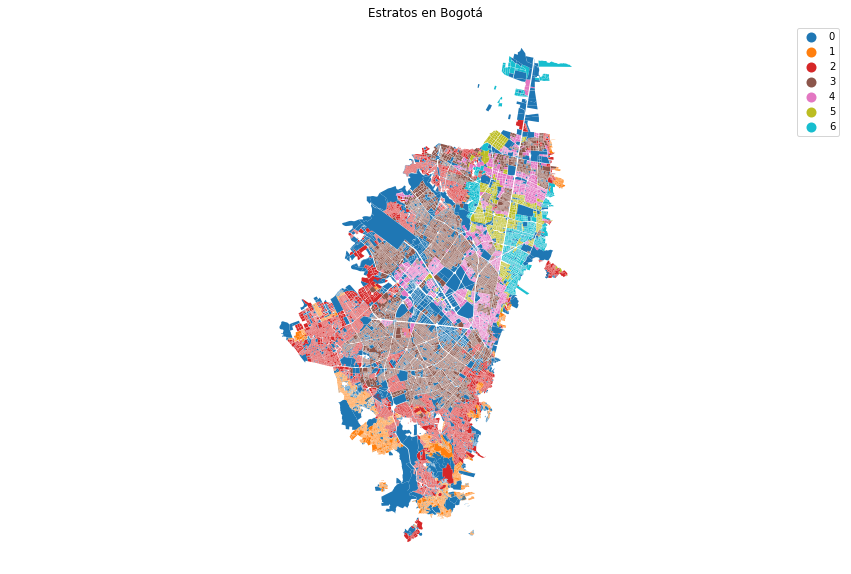

In [10]:
f, ax = plt.subplots(1, figsize=(15, 10))
ax.set_title(u'Estratos en Bogotá')

estratos.plot(column='estrato', categorical=True, legend=True, ax=ax)

ax.set_axis_off()
plt.axis('equal')

## Información localidades

### Cargue la información de las localidades. Conserve todas las localidades menos Sumapaz.

In [11]:
df_localidades = gpd.read_file('data/uber/bogota_localidades.geojson')
df_localidades = df_localidades.loc[df_localidades['CODIGO_LOC'] != '20'] # Filtrar Sumapaz

In [12]:
df_localidades.head()

,OBJECTID,NOMBRE,CODIGO_LOC,DECRETO,LINK,SIMBOLO,ESCALA_CAP,FECHA_CAPT,SHAPE_AREA,SHAPE_LEN,geometry
0,1,SANTA FE,3,Acuerdo 117 de 2003,None,None,None,None,4.517065e+07,43779.905440,"POLYGON ((-74.06856 4.62792, -74.06841 4.62880..."
1,11,PUENTE ARANDA,16,Acuerdo 8 de 1977,None,None,None,None,1.731115e+07,17854.555403,"POLYGON ((-74.11830 4.63741, -74.11504 4.64053..."
2,13,CIUDAD BOLIVAR,19,Acuerdo 14 de 1983,None,None,None,None,1.299864e+08,77732.027669,"POLYGON ((-74.15216 4.59976, -74.15218 4.59925..."
3,6,BARRIOS UNIDOS,12,Acuerdo 8 de 1977,None,None,None,None,1.190345e+07,13426.542795,"POLYGON ((-74.05725 4.68684, -74.06249 4.65594..."
4,2,SUBA,11,Acuerdo 8 de 1977,None,None,None,None,1.005606e+08,65665.349126,"POLYGON ((-74.04245 4.83066, -74.04242 4.83063..."


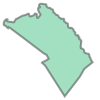

In [13]:
df_localidades.loc[7,'geometry']

In [14]:
localidades = df_localidades[['CODIGO_LOC', 'geometry', 'SHAPE_AREA']]
localidades.rename(index=str, columns={"SHAPE_AREA": "shape_area_loc"}, inplace=True)
localidades.head()

C:\Users\marco\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,CODIGO_LOC,geometry,shape_area_loc
0,3,"POLYGON ((-74.06856 4.62792, -74.06841 4.62880...",4.517065e+07
1,16,"POLYGON ((-74.11830 4.63741, -74.11504 4.64053...",1.731115e+07
2,19,"POLYGON ((-74.15216 4.59976, -74.15218 4.59925...",1.299864e+08
3,12,"POLYGON ((-74.05725 4.68684, -74.06249 4.65594...",1.190345e+07
4,11,"POLYGON ((-74.04245 4.83066, -74.04242 4.83063...",1.005606e+08


#### Unión entre estratos y localidades
Haga un **`spatial join`**, entre los estratos y las localidades. 

In [15]:
estratos_localidades = gpd.sjoin(estratos, localidades, how="inner", op='within')


In [16]:
estratos_localidades.drop(['index_right'], axis=1, inplace=True)
estratos_localidades.head()

,id,manzana,shape_area,shape_len,estrato,geometry,CODIGO_LOC,shape_area_loc
0,43421,00260601,61354.848985,1990.056871,2,"POLYGON ((-74.10285 4.51280, -74.10280 4.51270...",5,2.150664e+08
1,43460,00260549,595.400837,97.903820,0,"POLYGON ((-74.10205 4.51012, -74.10204 4.51003...",5,2.150664e+08
2,43453,00252714,1800.647864,169.204418,2,"POLYGON ((-74.10706 4.51039, -74.10704 4.51029...",5,2.150664e+08
3,43470,00260532,1137.075717,163.131125,1,"POLYGON ((-74.10374 4.50974, -74.10376 4.50962...",5,2.150664e+08
4,43486,00250606,2207.096432,232.198962,2,"POLYGON ((-74.10636 4.50909, -74.10631 4.50911...",5,2.150664e+08


#### Kennedy
Visualice solo las manzanas que pertenecen a Kennedy en el mapa de Bogotá.

In [17]:
df_kennedy=estratos_localidades.loc[estratos_localidades['CODIGO_LOC']=='8']

(-74.23244790000003, -73.98948209999999, 4.4353856, 4.8560783999999995)

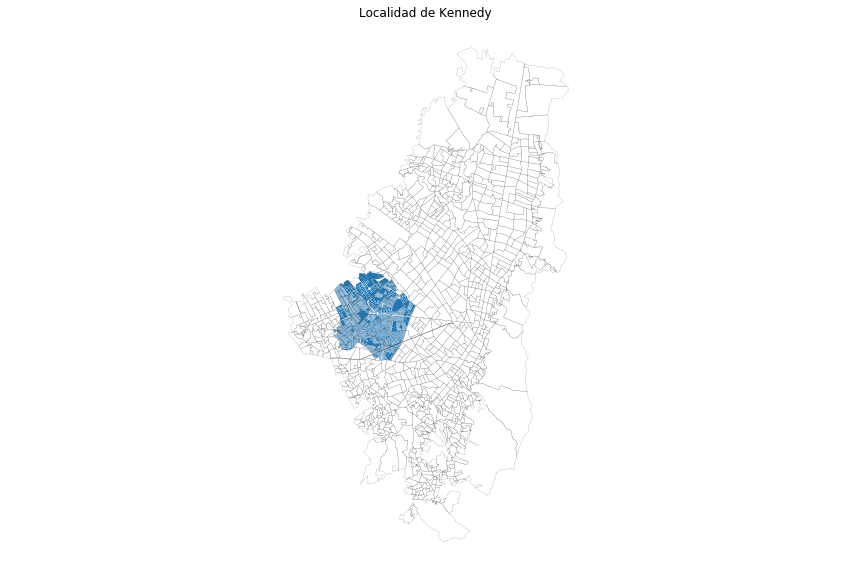

In [18]:
f, ax = plt.subplots(1, figsize=(15, 10))
ax.set_title(u'Localidad de Kennedy')

df_kennedy.plot(legend=True, ax=ax) # k nos permite controlar el número de clases para el mapa

df_bogota_filtered.plot(color='None', edgecolor='black', linewidth=0.1, ax=ax)

ax.set_axis_off()
plt.axis('equal')

(-74.23244790000003, -73.98948209999999, 4.4353856, 4.8560783999999995)

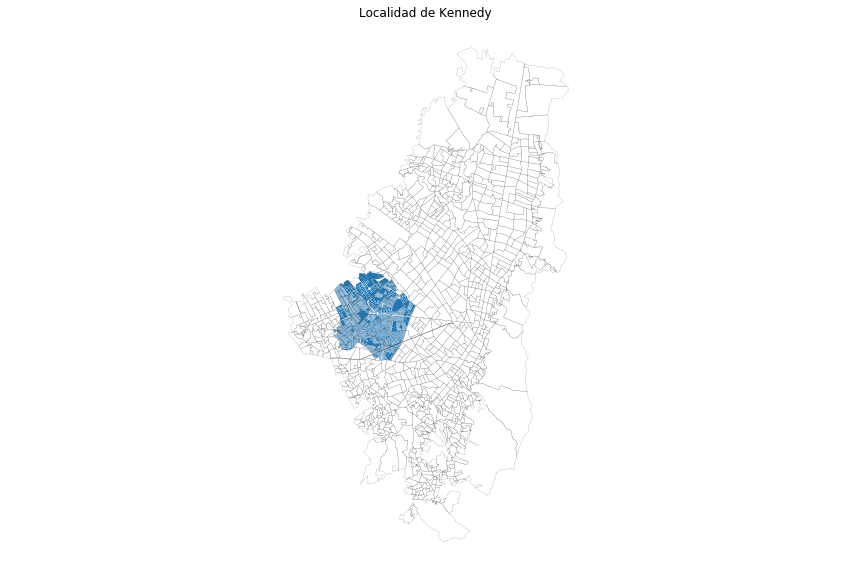

In [19]:
# NO MODIFIQUE ESTA CELDA

f, ax = plt.subplots(1, figsize=(15, 10))
ax.set_title(u'Localidad de Kennedy')

df_kennedy.plot(legend=True, ax=ax) # k nos permite controlar el número de clases para el mapa

df_bogota_filtered.plot(color='None', edgecolor='black', linewidth=0.1, ax=ax)

ax.set_axis_off()
plt.axis('equal')

## Distribución de estratos por localidad

A continuación encontramos que cada polígono tiene asociado un área. Vamos a hallar qué estrato tiene más porcentaje de área en Kennedy.

In [20]:
estratos_localidades.head()

,id,manzana,shape_area,shape_len,estrato,geometry,CODIGO_LOC,shape_area_loc
0,43421,00260601,61354.848985,1990.056871,2,"POLYGON ((-74.10285 4.51280, -74.10280 4.51270...",5,2.150664e+08
1,43460,00260549,595.400837,97.903820,0,"POLYGON ((-74.10205 4.51012, -74.10204 4.51003...",5,2.150664e+08
2,43453,00252714,1800.647864,169.204418,2,"POLYGON ((-74.10706 4.51039, -74.10704 4.51029...",5,2.150664e+08
3,43470,00260532,1137.075717,163.131125,1,"POLYGON ((-74.10374 4.50974, -74.10376 4.50962...",5,2.150664e+08
4,43486,00250606,2207.096432,232.198962,2,"POLYGON ((-74.10636 4.50909, -74.10631 4.50911...",5,2.150664e+08


#### Total de área por localidad y estrato

Vamos a generar el total de área por localidad y estrato. Para esto se debe generar un groupby de pandas usando las columnas `CODIGO_LOC` y `estrato`. Recuerde llamar `.reset_index()` para que la localidad y el estrato sigan siendo columnas del nuevo dataframe.

In [21]:
areas_groupings=estratos_localidades.groupby(['CODIGO_LOC','estrato'])['shape_area'].sum().reset_index()

In [22]:
areas_groupings.head()

,CODIGO_LOC,estrato,shape_area
0,1,0,7.658636e+06
1,1,1,7.703923e+05
2,1,2,1.232852e+06
3,1,3,3.893668e+06
4,1,4,4.454413e+06


Añada una columna adicional que contenga el área total de cada localidad. 

In [23]:
area_estratos_localidad=pd.merge(areas_groupings,localidades[['CODIGO_LOC','shape_area_loc']], on='CODIGO_LOC')

In [24]:
area_estratos_localidad.head()

,CODIGO_LOC,estrato,shape_area,shape_area_loc
0,1,0,7.658636e+06,6.531573e+07
1,1,1,7.703923e+05,6.531573e+07
2,1,2,1.232852e+06,6.531573e+07
3,1,3,3.893668e+06,6.531573e+07
4,1,4,4.454413e+06,6.531573e+07


In [25]:
area_estratos_localidad['ratio'] = area_estratos_localidad['shape_area']/area_estratos_localidad['shape_area_loc']

Usando plotly, visualice el porcentaje de área por estrato en la localidad de Kennedy

In [26]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *

import cufflinks as cf

init_notebook_mode(connected=True)
cf.go_offline()

strata = area_estratos_localidad.loc[area_estratos_localidad['CODIGO_LOC'] == '8', 'estrato']

ratio = area_estratos_localidad.loc[area_estratos_localidad['CODIGO_LOC'] == '8', 'ratio']

In [27]:
#ratio.head()
df = pd.DataFrame({'Category':strata,'Values':ratio})
#data_bar = Bar(x= df['Category'], y= df['Values'], marker=dict(color='#F0B2B9'))
#layout = Layout(title= dict(title='Distribución de área en Kennedy'),
#                    xaxis=dict(title='Estrato'),
#                    yaxis=dict(title='Área'))
#fig = Figure(data=data_bar, layout=layout)
#iplot(fig)
#df.iplot(kind='bar',x='Category',y='Values',xTitle='Estrato',yTitle='Área',title='Distribución de área en Kennedy', theme='white',colors='#F0B2B9',opacity=1)


trace0 = Bar(
    x=strata,
    y=ratio,
    #text=['27% market share', '24% market share', '19% market share'],
    marker=dict(
        color='#F0B2B9',
        line=dict(
            color='#F0B2B9',
            width=1.5,
        )
    ),
    opacity=0.6
)

data = [trace0]
layout = Layout(
    title='Distribución de área en Kennedy',
    xaxis=dict(title='Estrato'),
    yaxis=dict(title='Área'),
    width=750, height=500,
)

fig = Figure(data=data, layout=layout)
iplot(fig, filename='text-hover-bar')